In [1]:
import pandas as pd
from warnings import simplefilter; simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
dem_={};gluc_={};crp_={};cbc_={};mortality_={}
cbc_sub=['LBXRDW','LBXWBCSI','LBXLYPCT','LBDLYMNO','LBXRBCSI','LBXHGB','LBXPLTSI']

/Users/mahdimoqri/opt/miniconda3/envs/longevity/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
year=2010
dem_[year]='https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/DEMO_F.XPT'
gluc_[year]='https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/GLU_F.XPT'
#crp_[year]='https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/CRP_F.XPT'
cbc_[year]='https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/CBC_F.XPT'
mortality_[year]='https://ftp.cdc.gov/pub/Health_Statistics/NCHS/datalinkage/linked_mortality/NHANES_2009_2010_MORT_2019_PUBLIC.dat'
dem=pd.read_sas(dem_[year],index='SEQN')[['RIAGENDR','RIDAGEYR']]
dem.index=dem.index.astype(int)
gluc=pd.read_sas(gluc_[year],index='SEQN')['LBDGLUSI']
gluc.index=gluc.index.astype(int)
#crp=pd.read_sas(crp_[year],index='SEQN')['LBXCRP']
#crp.index=crp.index.astype(int)
cbc=pd.read_sas(cbc_[year],index='SEQN')[cbc_sub]
cbc.index=cbc.index.astype(int)
mort=pd.read_fwf(mortality_[year],index_col=0,header=None,widths=[14,1,1,3,1,1,1,4,8,8,3,3])
mort.index=mort.index.rename('SEQN')
dead=mort[mort[1]==1][[2,10]].astype(int)
dead.columns=['MORTSTAT','PERMTH_EXM']
df=pd.concat([dem,gluc,cbc,dead],axis=1).dropna()
df=df.rename({'LB2RDW':'LBXRDW','LB2WBCSI':'LBXWBCSI'},axis=1)
df.to_csv(str(year)+'.csv')

In [3]:
df=pd.read_csv('2010.csv',index_col=0)

<Axes: xlabel='timeline'>

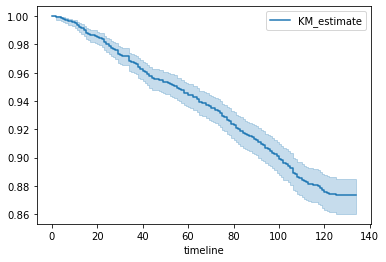

In [4]:
T=df.PERMTH_EXM
E=df.MORTSTAT
kmf = KaplanMeierFitter()
kmf.fit(T, E)  
kmf.plot()

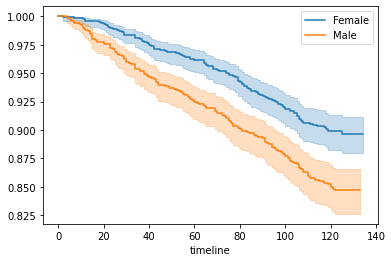

In [5]:
ax=plt.subplot()
groups = df['RIAGENDR']
ix = (groups == 2)
kmf.fit(T[ix], E[ix], label='Female')
ax = kmf.plot_survival_function(ax=ax)
kmf.fit(T[~ix], E[~ix], label='Male')
ax = kmf.plot_survival_function()

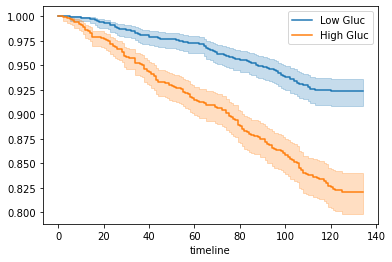

In [7]:
ax=plt.subplot()
groups = df['LBDGLUSI']
ix = (groups < 5.5)
kmf.fit(T[ix], E[ix], label='Low Gluc')
ax = kmf.plot_survival_function(ax=ax)
kmf.fit(T[~ix], E[~ix], label='High Gluc')
ax = kmf.plot_survival_function()

In [8]:
year=2012
dem_[year]='https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/DEMO_G.XPT'
gluc_[year]='https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/GLU_G.XPT'
#crp_[year]='https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/CRP_G.XPT'
cbc_[year]='https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/CBC_G.XPT'
mortality_[year]='https://ftp.cdc.gov/pub/Health_Statistics/NCHS/datalinkage/linked_mortality/NHANES_2011_2012_MORT_2019_PUBLIC.dat'
dem=pd.read_sas(dem_[year],index='SEQN')[['RIAGENDR','RIDAGEYR']]
dem.index=dem.index.astype(int)
gluc=pd.read_sas(gluc_[year],index='SEQN')['LBDGLUSI']
gluc.index=gluc.index.astype(int)
#crp=pd.read_sas(crp_[year],index='SEQN')['LBXCRP']
#crp.index=crp.index.astype(int)
cbc=pd.read_sas(cbc_[year],index='SEQN')[cbc_sub]
cbc.index=cbc.index.astype(int)
mort=pd.read_fwf(mortality_[year],index_col=0,header=None,widths=[14,1,1,3,1,1,1,4,8,8,100])
mort.index=mort.index.rename('SEQN')
dead=mort[mort[1]==1][2].astype(int)
dead=dead.rename('MORTSTAT')
df=pd.concat([dem,gluc,cbc,dead],axis=1).dropna()
df=df.rename({'':''},axis=1)
df.to_csv(str(year)+'.csv')

In [9]:
df=pd.read_csv('2012.csv',index_col=0)
X_train=df[['RIDAGEYR','RIAGENDR','LBDGLUSI']+cbc_sub]
y_train=df['MORTSTAT']

In [10]:
logreg= LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [11]:
df=pd.read_csv('2010.csv',index_col=0)
X_test=df[['RIDAGEYR','RIAGENDR','LBDGLUSI']+cbc_sub]
y_test=df['MORTSTAT']

In [12]:
y_pred=logreg.predict(X_test)
y_pred_proba= logreg.predict_proba(X_test) [::,1]

In [13]:
false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)
auc= metrics.roc_auc_score(y_test, y_pred_proba)

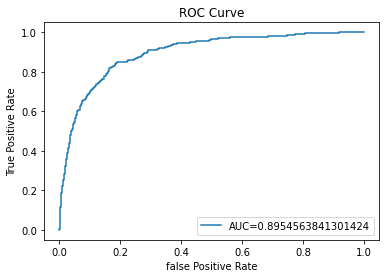

In [14]:
plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94      2555
         1.0       0.71      0.27      0.39       358

    accuracy                           0.90      2913
   macro avg       0.81      0.63      0.67      2913
weighted avg       0.88      0.90      0.88      2913



In [16]:
df['Biological Age']=y_pred

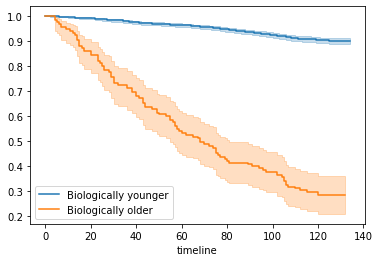

In [17]:
ax=plt.subplot()
groups = df['Biological Age']
ix = (groups == 0)
kmf.fit(T[ix], E[ix], label='Biologically younger')
ax = kmf.plot_survival_function(ax=ax)
kmf.fit(T[~ix], E[~ix], label='Biologically older')
ax = kmf.plot_survival_function()

In [18]:
df.columns

Index(['RIAGENDR', 'RIDAGEYR', 'LBDGLUSI', 'LBXRDW', 'LBXWBCSI', 'LBXLYPCT',
       'LBDLYMNO', 'LBXRBCSI', 'LBXHGB', 'LBXPLTSI', 'MORTSTAT', 'PERMTH_EXM',
       'Biological Age'],
      dtype='object')

In [19]:
year=2010
df.to_csv(str(year)+'.csv')